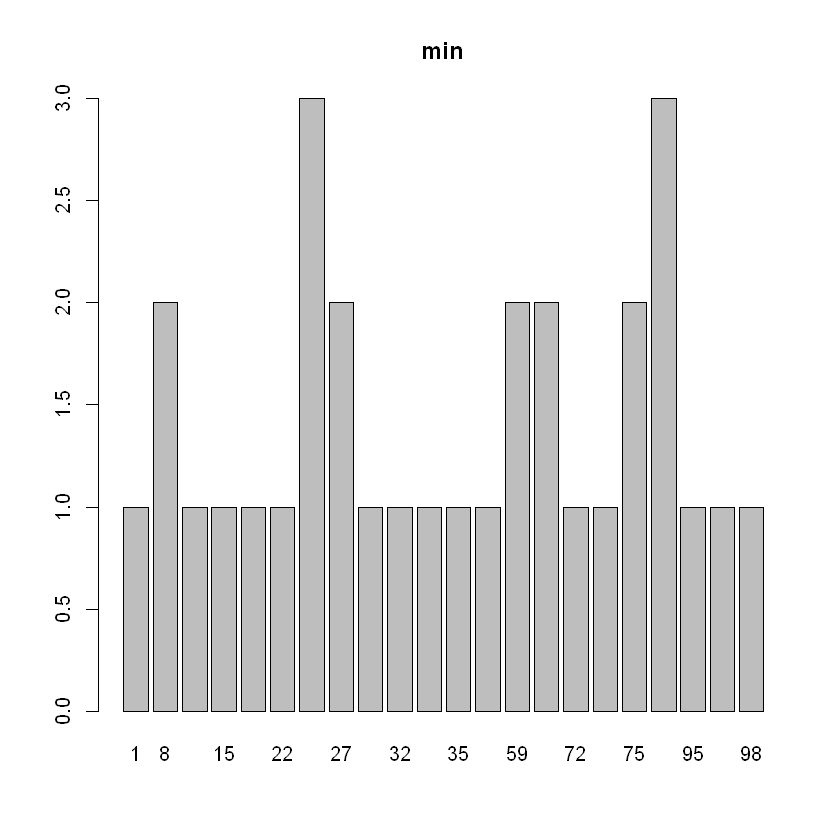

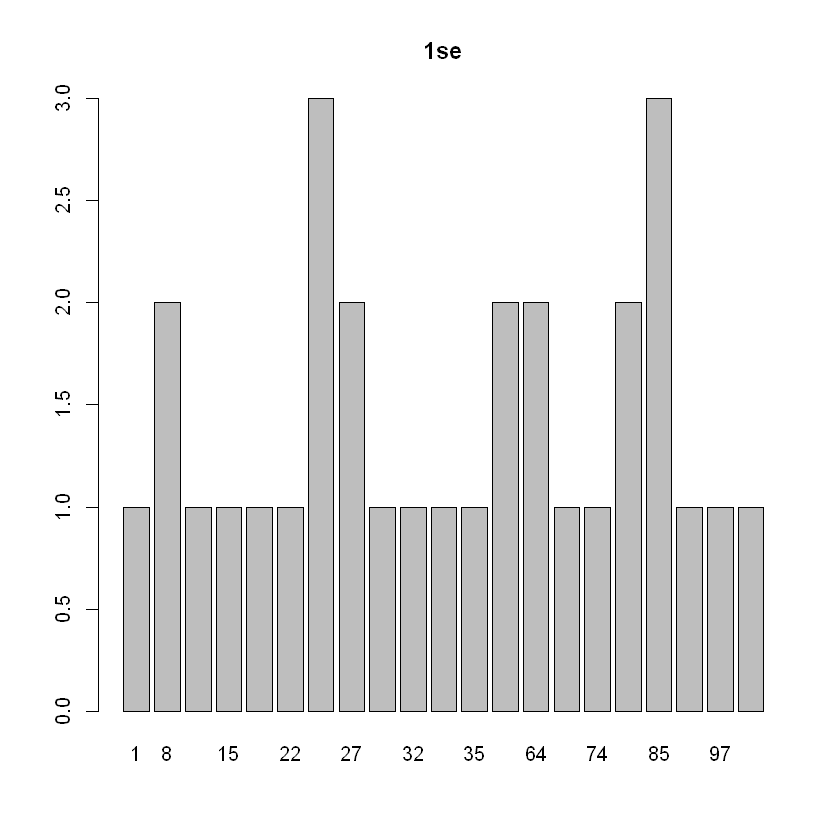

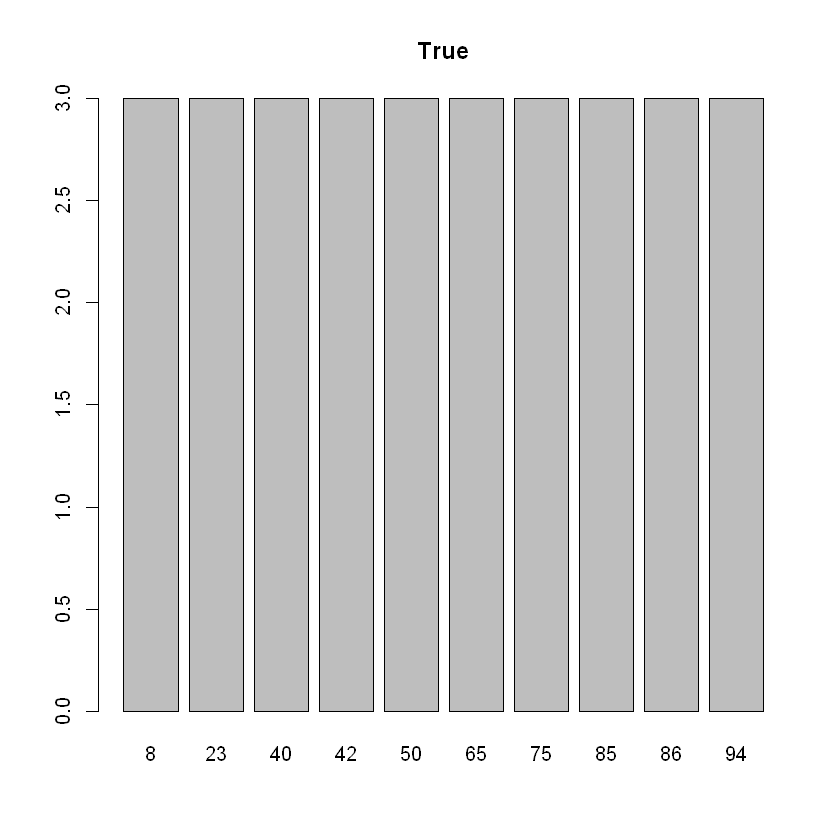

In [3]:
library(glmnet)

# Feature selection and regularised regression


#Goal: give us an impression of what these methods can be used for, but
# also what limitations they have.


#WARNING: Both parts of assignment require some amount of repeated simulation/
# estimation of models which can take some time to run!

## ---- PART 1: Prediction quality vs feature selection ------------------------

# Lasso encodes variable selection through penalisation. 
#install.packages("tidyverse")
#install.packages("glmnet", repos = "https://cran.us.r-project.org")
library(tidyverse)
library(latex2exp)

# Simulating data: 

#' 
#' @param n Number of samples 
#' @param p Number of features
#' @param sparsity Percentage of zero elements in simulated regression coefficients
#' @param SNR Signal-to-noise ratio (see explanation above)
#' @param scaling.beta Scaling for the coefficient to make sure they are large
#' 
#' @return A list containing
#     {X}{n x p matrix of features}
#     {y}{n vector of responses}
#     {beta}{p vector of regression coefficients}

## ---- Simulating data --------------------------------------------------------



sim.data.corr <- function(n, p, sparsity, SNR = 2, scaling.beta = 5){

  # Standardisation function
  stand. <- function(x) {
    x <- (x - mean(x)) / sd(x)
  }
  
  
  
  #ps <- sum(p)
  
  
  # Decide how correlated variables
  corr.1 <- 0.1
  #corr.2 <- 0.2
  #corr.3 <- 0.3
  
  # NOTE: this is how much noise one addds to the identical feature copies in the 
  # groups -> smaller value of corr.X = higher correlation between variables 
  # (a.k.a less noise added)
  
  # Create correlated variables 

  X<-rnorm(n)
  X<-matrix(rep(X,p[1]),n,p[1],byrow=F)+matrix(rnorm(n*p[1],sd=corr.1),n,p[1])
  X<-apply(X,2,stand.)
  
  
  # #
  # x2<-rnorm(n)
  # x2<-matrix(rep(x2,p[2]),n,p[2],byrow=F)+matrix(rnorm(n*p[2],sd=corr.2),n,p[2])
  # x2<-apply(x2,2,stand.)
  # #
  # x3<-rnorm(n)
  # x3<-matrix(rep(x3,p[3]),n,p[3],byrow=F)+matrix(rnorm(n*p[3],sd=corr.3),n,p[3])
  # x3<-apply(x3,2,stand.)
  # 
  # 
  # #  a fourth group with no correlation
  # x4<-matrix(rnorm(n*p[4]),n,p[4])
  # x4<-apply(x4,2,stand.)
  # 
  # 
  #X <- matrix(rnorm(n*p), ncol = p) # nXp design matrix 
  
  
  
  
  
  non.zero.coeff <- ceiling((1-sparsity)*p) # Number of non-zero coeff
  
  # ceiling will take a numeric number (such as 1.1) and return the integer
  # closest and higher in value to this number (so 2 in my example)
  
  beta <- rep.int(0,p) #initialise 1Xp vector with 0
  
  beta[1:non.zero.coeff] <- scaling.beta * rnorm(non.zero.coeff) # Insert q scaled coeff from sd normal dist
  
  # (sd is beta_scale for the betas)
  
  
  # I think what we are doing here is basically creating some noise/
  # a sample
  # beta*X is the noise-less response
  # beta*X + sigma*epsilon is the actual response
  # sigma = sd_noise = sd_signal/SNR - we generate a reasonable noise sd
  
  # (So basically like we did with beta_scale above, we want to rescale
  # our random error so that we get reasonable results)
  sd.noise <- sqrt(sum((X %*% beta)^2)/(n-1))/SNR 
  
  
  y <- X%*%beta + sd.noise * rnorm(n) # Response 
  
  # We do not want the non-zero features in the first (1-sparsity)p 
  # number of columns only, so we reorder the columns:
  
  reord <- sample(p, p, replace = F)
  
  
  #X <- cbind(x1,x2,x3,x4)
  
  
  
  list(
    
    X = X[, reord],
    y = y,
    beta = beta[reord]
  )
  
}

## ---- Correlated data via demo 10 --------------------------------------------


library(MASS)









M  = 3
p = 100
n <- 750

sparsity <- 0.9

labels.min <- matrix(0, nrow = p+5, ncol = M)
labels.1se <- matrix(0, nrow = p+5, ncol = M)
labels.true <- matrix(0, nrow = p+5, ncol = M)

return <- sim.data.corr(n,p,sparsity)

suppressMessages(attach(return))

coeff.min <- matrix(0, nrow = p+1, ncol = M)

coeff.1se <- matrix(0, nrow = p+1, ncol = M)


boot.data.X <- matrix(0, nrow = n, ncol = 100)
boot.lab.y <- matrix(0, nrow = n, ncol = 1)

# Record how often each feature got selected for each class across bootstrap samples. 
# You will essentially get a histogram where larger peaks indicate that a feature was chosen more often.


# Initiate vector for labels (nrow is arbitrary number < M)
# labels.BRCA <- matrix(0, nrow = 100, ncol = M)
# labels.LUAD <- matrix(0, nrow = 100, ncol = M)
# labels.KIRC <- matrix(0, nrow = 100, ncol = M)
# labels.PRAD <- matrix(0, nrow = 100, ncol = M)
# labels.COAD <- matrix(0, nrow = 100, ncol = M)


# Loop to create M bootstrap models
for ( i in 1:M) {
  
  # The bootstrapped data (replace = T is important!)
  #boot.data <- data.filtered[,sample(ncol(data.filtered), size = 200, replace = TRUE)]
  
  # Row id for bootstrapping
  id <- sample(n, size = n, replace = T)
  
  # Bootstrapped data and labels
  boot.data.X <- X[id,]
  boot.lab.y <- y[id,]
  
  # Create model for bootstrapped data
  cv.mod <- cv.glmnet(
    x = boot.data.X, y = boot.lab.y,
    keep = T,
    alpha = 1,
    type.measure = "mse")
    
  
  features <- c(1:p)
  
  coeff.m <- as.data.frame(cbind(features,as.vector(coef(cv.mod, s = "lambda.min")[-1])))
  coeff.1 <- as.data.frame(cbind(features,as.vector(coef(cv.mod, s = "lambda.1se")[-1])))
  
  beta.true <- as.data.frame(cbind(features,as.vector(return$beta)))
  
  
  non.zero.coeff.min <- coeff.m[coeff.m[,2] != 0,]
  non.zero.coeff.1se <- coeff.1[coeff.1[,2] != 0,]
  
  non.zero.coeff.true <- beta.true[beta.true[,2] != 0,]
  
  labels.min[c(1:dim(non.zero.coeff.min)[1]),i] <- non.zero.coeff.min[,1]
  #   
  labels.1se[c(1:dim(non.zero.coeff.1se)[1]),i] <- non.zero.coeff.1se[,1]
  
  labels.true[c(1:dim(non.zero.coeff.true)[1]),i] <- non.zero.coeff.true[,1]
  
    
}

# # Barplot for the genes with non-zero coef (to see freq over M)
 all.min <- as.data.frame(labels.min[labels.min != 0])
# 
 barplot(table(all.min), main = "min")
# 
 all.1se <- as.data.frame(labels.1se[labels.1se != 0])
# 
 barplot(table(all.1se), main = "1se")

 all.true <- as.data.frame(labels.true[labels.true != 0])
 # 
 barplot(table(all.true), main = "True")

#list(labels.true == labels.1se)

#list(labels.true == labels.min)

,all.min,Freq
,<fct>,<int>
9,9,5
17,18,6
24,25,6
33,35,6
42,44,6
47,52,6
49,54,6
59,65,6
71,77,6


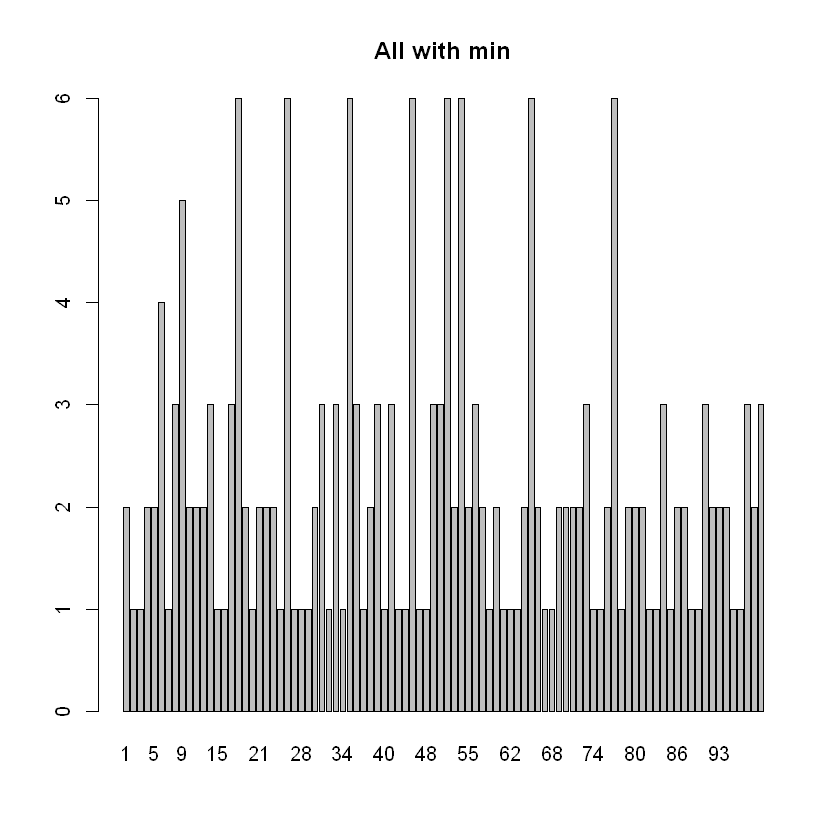

,all.1se,Freq
,<fct>,<int>
3,9,5
6,18,6
9,25,6
13,35,6
19,44,6
22,52,6
27,65,6
32,77,6


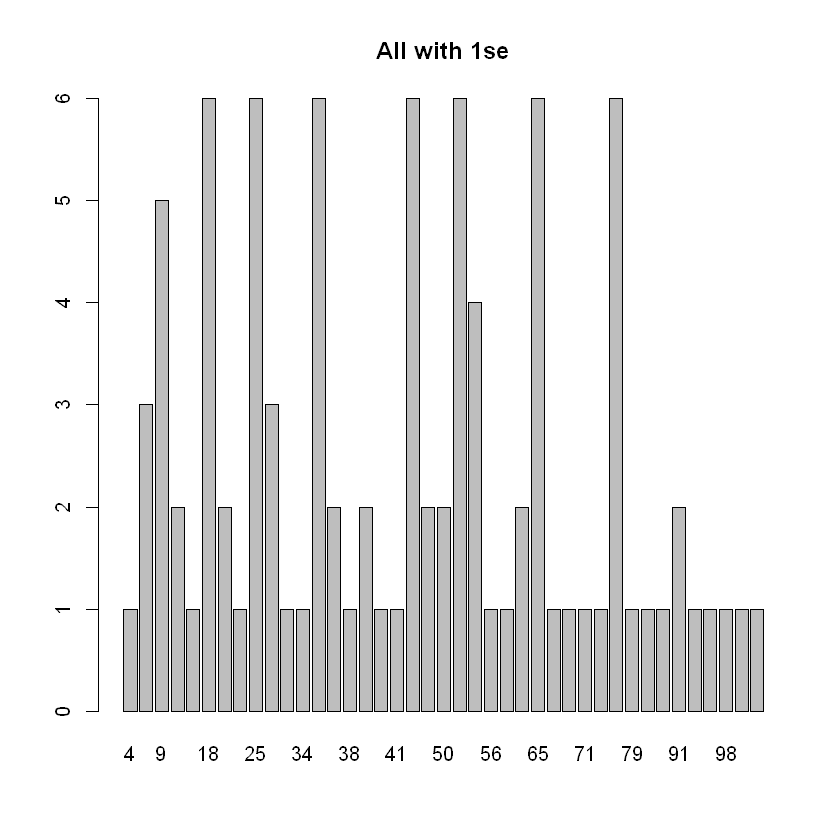

,all,Freq
,<fct>,<int>
9,9,7
17,18,9
24,25,9
29,31,6
33,35,9
34,36,5
37,39,5
42,44,9
45,49,5


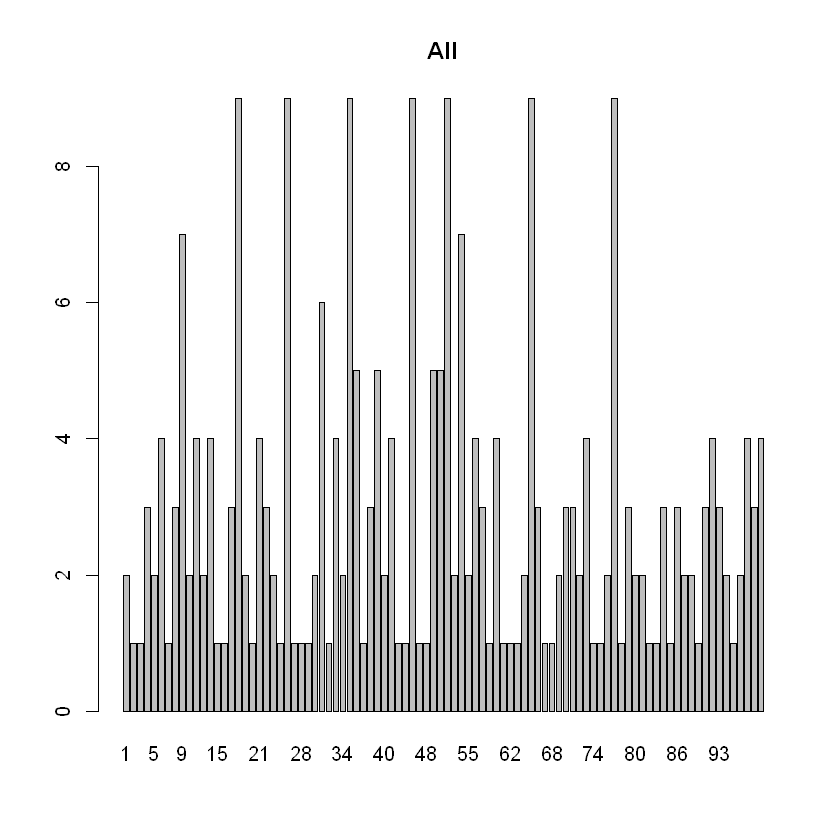

In [2]:
# Which variables are frequent in both true and min model?

all.min <- cbind(labels.min,labels.true)

all.min <- as.data.frame(all.min[all.min !=0])

barplot(table(all.min), main = "All with min")

count.all.min <- as.data.frame(table(all.min))

top.count.all.min <- count.all.min[count.all.min$Freq > 4,]

best.count.all.min <- count.all.min[count.all.min$Freq == 9,]

list(top.count.all.min)

# Which variables are frequent in both true and 1se model?

all.1se <- cbind(labels.1se,labels.true)

all.1se <- as.data.frame(all.1se[all.1se !=0])

barplot(table(all.1se), main = "All with 1se")

count.all.1se <- as.data.frame(table(all.1se))

top.count.all.1se <- count.all.1se[count.all.1se$Freq > 4,]

best.count.all.1se <- count.all.1se[count.all.1se$Freq == 9,]

list(top.count.all.1se)

# Which variables are frequent in both true and 1se model?

all <- cbind(labels.1se,labels.min, labels.true)

all <- as.data.frame(all[all !=0])

barplot(table(all), main = "All")

count.all <- as.data.frame(table(all))

top.count.all <- count.all[count.all$Freq > 4,]

best.count.all <- count.all[count.all$Freq == 9,]

list(top.count.all)